# Image scene classification using Neural Network

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.layers import Flatten
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
base_path = './storage/data/'
train_path = './storage/data/seg_train/'
img_size = 150
train_data = {}
test_data = {}
labels = ['buildings', 'sea', 'glacier', 'mountain', 'forest', 'street']
folder_2_class = {'buildings': 0, 'sea': 1, 'glacier':2, 'mountain':3, 'forest':4, 'street':5}

## Data Expoloration 

In [3]:
#method to print directory structure
def explore_dir(path, train_data, test_data, labels):
    print("Directory structure of base directory", base_path)
    n_train = 0
    n_test = 0
    for dr in os.listdir(base_path):
        print("\t",dr)
        if dr == 'seg_pred':
            print("\t\t Number of files", len(os.listdir(base_path + dr + '/' )))
        else:
            for dr2 in os.listdir(base_path + dr + '/'):
                            print('\t\t\t',dr2)
                            print("\t\t\t\t Number of files", len(os.listdir(base_path + dr + '/' + dr2 + "/")))
                            if (dr == 'seg_train'):
                                n_train = n_train + len(os.listdir(base_path + dr + '/' + dr2 + "/"))
                                train_data[dr2] =  len(os.listdir(base_path + dr + '/' + dr2 + "/"))
                                labels.append(dr2)
                            elif(dr == 'seg_test'):
                                n_test = n_test + len(os.listdir(base_path + dr + '/' + dr2 + "/"))
                                test_data[dr2] =  len(os.listdir(base_path + dr + '/' + dr2 + "/"))

In [48]:
#method to show sample images form train set
def sample_plots(path):
    print_dataset = ImageDataGenerator()
    print_gen = print_dataset.flow_from_directory(
               path,  # this is the target directory
                target_size=(img_size, img_size),
                batch_size=30,
                classes = labels)  
    figsize=(12,13)
    rows=5
    interp=False
    ims, titles = next(print_gen)
    if type(ims[0]) is np.ndarray:
        ims=np.array(ims).astype(np.uint8)
        if (ims.shape[-1]!=3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('off')
        if titles is not None:
            val, = np.where(titles[i]==1)
            sp.set_title(labels[val[0]], fontsize=13)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

#### Lets explore directory structure for the dataset and see how our data is stored

In [4]:
explore_dir(base_path, train_data, test_data, labels)

Directory structure of base directory ./storage/data/
	 seg_pred
		 Number of files 7301
	 seg_train
			 buildings
				 Number of files 2628
			 sea
				 Number of files 2785
			 glacier
				 Number of files 2957
			 mountain
				 Number of files 3037
			 forest
				 Number of files 2745
			 street
				 Number of files 2883


#### Lets see the amount of test and train data we have for each class 

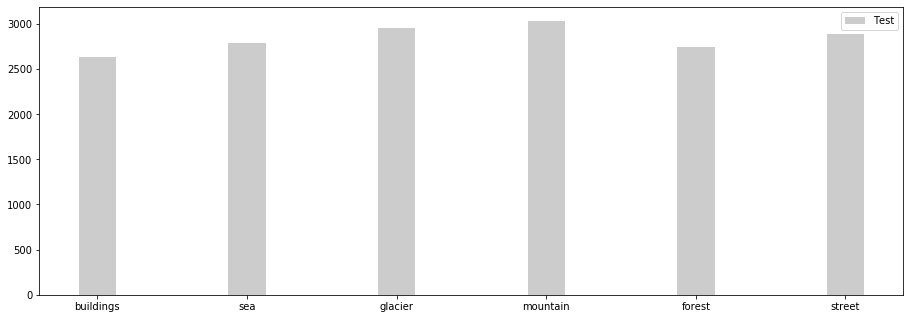

In [5]:
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
X = np.arange(6)
ax.bar(X, tuple(train_data.values()), color=(0.8, 0.8, 0.8, 1), width=0.25)
ax.set_xticks(X)
ax.set_xticklabels(labels)
ax.legend(labels=['Test', 'Train'])
plt.show()

#### Pre processing data 

Get the data and labels into array and lables for model training

In [3]:
train_data = []
train_label = []

for ex in os.listdir(train_path):
    for i in range(0,len(os.listdir(train_path+ex+'/'))):
        path = train_path+ex+'/'+os.listdir(train_path + ex)[i]
        extension = path.split(".")[-1] in ("jpg", "jpeg", "png")
        if extension:
            img = load_img(path, target_size=(img_size, img_size))
            img_arr = img_to_array(img)
            train_data.append(img_arr)
            train_label.append(folder_2_class.get(ex))

In [24]:
print(len(train_data), len(train_label))

17034 17034


Shuffling and normaliszing the data

In [4]:
#shfulling the data
train_data, train_label = shuffle(train_data, train_label)

train_data=np.array(train_data)/255.0
train_data=np.reshape(train_data,(train_data.shape[0],img_size,img_size,3))
train_label=np.array(train_label)
train_label = to_categorical(train_label)

Split into test and train

In [5]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.2)

#### Print some sample images 

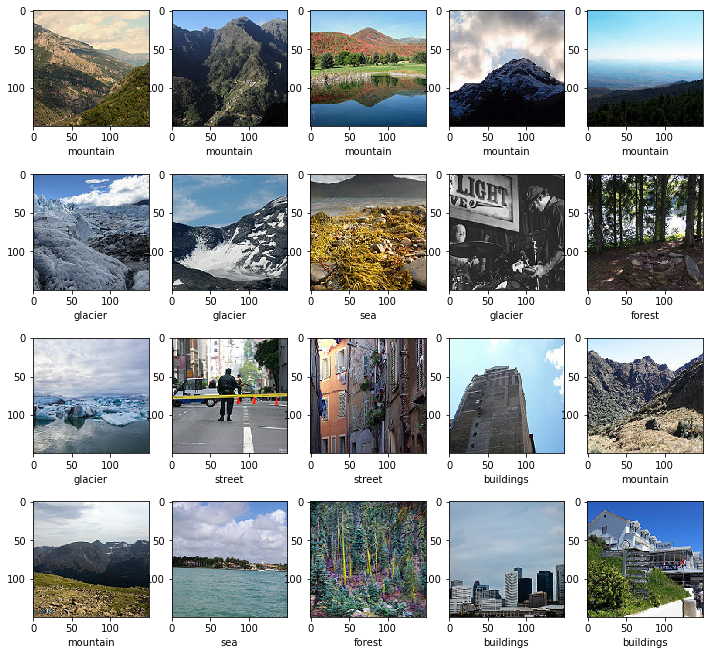

In [9]:
plt.figure(0, figsize=(12, 150))
cpt = 0
for img in train_data:
    cpt = cpt + 1
    ax = plt.subplot(50, 5, cpt)
    img_ = array_to_img(img)
    plt.imshow(img_)
    ax.set_xlabel(labels[train_label[cpt-1]])
    if cpt == 20:
        break

## Hyperparameter Tuning

In [16]:
def model_create_optmiser(optimizer='Adam'):
    model = tf.keras.models.Sequential()

    # input layer 
    model.add(tf.keras.layers.Conv2D(64, (3,3), input_shape=(img_size, img_size, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    # Hidden layer 2
    model.add(tf.keras.layers.Conv2D(32, (3, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))  
    
    #flatting
    model.add(tf.keras.layers.Flatten())    
    model.add(tf.keras.layers.Dense(units=128))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Dense(units=6))
    model.add(tf.keras.layers.Activation('softmax'))
    
   # model compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [17]:
batch_size_list = [30, 40, 50]
epochs_list = [24, 32]
optimizer_list = ['SGD', 'RMSprop', 'Adam']

parameters = dict(batch_size=batch_size_list, epochs=epochs_list, optimizer=optimizer_list)
model = KerasClassifier(build_fn=model_create_optmiser, verbose=0)

grid = GridSearchCV(estimator=model, param_grid=parameters, cv=3)
X_train, y_train =  train_datagen.next()
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']

params = grid_result.cv_results_['params']

#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.436364 using {'batch_size': 40, 'epochs': 32, 'optimizer': 'Adam'}


The best accuracy score is the using Best: 0.436364 using {'batch_size': 40, 'epochs': 32, 'optimizer': 'Adam'} so we will be using Adam for further parameter tunning. 

In [25]:
def model_create_optmiser(learn_rate=0.01):
    model = tf.keras.models.Sequential()

    # input layer 
    model.add(tf.keras.layers.Conv2D(64, (3,3), input_shape=(img_size, img_size, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    
    # Hidden layer 2
    model.add(tf.keras.layers.Conv2D(32, (3, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))  
    
    #flatting
    model.add(tf.keras.layers.Flatten())    
    model.add(tf.keras.layers.Dense(units=128))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Dense(units=6))
    model.add(tf.keras.layers.Activation('softmax'))
    
     #optimizer
    optimizer = tf.keras.optimizers.Adam(lr=learn_rate)
  
    # model compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [26]:
batch_size_list = [16,24,32]
epochs_list = [20, 30, 40]

lr = [0.0001, 0.001, 0.01]
momentum = [0.4, 0.5, 0.6]
parameters = dict(learn_rate=lr, batch_size=batch_size_list, epochs=epochs_list)
X_train, y_train =  train_datagen.next()
model = KerasClassifier(build_fn=model_create_optmiser, verbose=0)

grid = GridSearchCV(estimator=model, param_grid=parameters, cv=3)
#X_train, y_train =  train_datagen.next()
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']

params = grid_result.cv_results_['params']


Best: 0.439394 using {'batch_size': 16, 'epochs': 20, 'learn_rate': 0.001}


We get the best score using {'batch_size': 16, 'epochs': 20, 'learn_rate': 0.001} so we will be using these to tune the model. 

## Modle Training

In [12]:
batch_size = 16
epochs = 20 
learn_rate = 0.001

In [13]:
def model_create_optmiser(learn_rate):
    model = tf.keras.models.Sequential()

    # input layer 
    model.add(tf.keras.layers.Conv2D(64, (3,3), input_shape=(img_size, img_size, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    # Hidden layer 2
    model.add(tf.keras.layers.Conv2D(32, (3, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))  
    
    #flatting
    model.add(tf.keras.layers.Flatten())    
    model.add(tf.keras.layers.Dense(units=128))
    model.add(tf.keras.layers.Dropout(0.4))

    model.add(tf.keras.layers.Dense(units=6))
    model.add(tf.keras.layers.Activation('softmax'))
    
     #optimizer
    optimizer = tf.keras.optimizers.Adam(lr=learn_rate)
  
    # model compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [14]:
model_final = model_create_optmiser(learn_rate=learn_rate)

In [7]:
train_datagen_fnl , test_datagen_fnl, val_datagen_fnl = image_datagen_fnl(base_path)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [15]:
history = model_final.fit(X_train,
                          y_train,
                          epochs=epochs,
                          validation_split=0.2)

Train on 10901 samples, validate on 2726 samples
Epoch 1/20
10901/10901 [==============================] - 13s 1ms/sample - loss: 1.2144 - accuracy: 0.5578 - val_loss: 0.8882 - val_accuracy: 0.6728
Epoch 2/20
10901/10901 [==============================] - 10s 904us/sample - loss: 0.8475 - accuracy: 0.6819 - val_loss: 0.7806 - val_accuracy: 0.7109
Epoch 3/20
10901/10901 [==============================] - 10s 904us/sample - loss: 0.6676 - accuracy: 0.7538 - val_loss: 0.8024 - val_accuracy: 0.6871
Epoch 4/20
10901/10901 [==============================] - 10s 903us/sample - loss: 0.5241 - accuracy: 0.8107 - val_loss: 0.7585 - val_accuracy: 0.7384
Epoch 5/20
10901/10901 [==============================] - 10s 900us/sample - loss: 0.3978 - accuracy: 0.8584 - val_loss: 0.8597 - val_accuracy: 0.7230
Epoch 6/20
10901/10901 [==============================] - 10s 901us/sample - loss: 0.2832 - accuracy: 0.9018 - val_loss: 0.9914 - val_accuracy: 0.7183
Epoch 7/20
10901/10901 [=======================

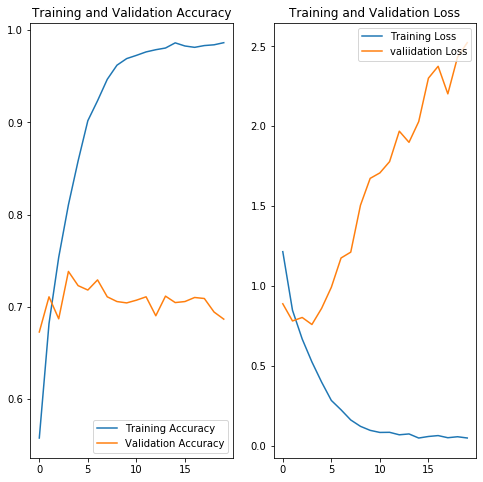

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='valiidation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
scoreSeg = model_final.evaluate(X_test, y_test, verbose=0)
print("Test loss, Test accuracy:", scoreSeg)

Test loss, Test accuracy: [0.6628810317909464, 0.74766666]


In [12]:
model_final.save('saved_model/normal_model')

INFO:tensorflow:Assets written to: saved_model/normal_model/assets


In [13]:
model_final.save('saved_model/normal_model.h5')

# Image scene classification using Transfer Learning

In [7]:
def model_create_optmiser_tnfrlr(optimizer='Adam'):
    base_model = vgg16.VGG16( include_top=False, weights="imagenet", input_shape=(img_size, img_size, 3))
    base_model.trainable = False
    for layer in base_model.layers:
        if ('block5'in layer.name):   # or ('block4'in layer.name):
            layer.trainable = True 
    
    x_op = base_model.output
    x = tf.keras.layers.Flatten()(x_op)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    output = tf.keras.layers.Dense(6, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.inputs, outputs=output) 
      
    #optimizer
#    optimizer = tf.keras.optimizers.Adam(lr=learn_rate)    
    # model compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
batch_size_list = [16, 24, 32]
epochs_list = [5, 10, 15]
optimizer_list = ['SGD', 'Adam']

parameters = dict(batch_size=batch_size_list, epochs=epochs_list, optimizer=optimizer_list)
model_transfer = KerasClassifier(build_fn=model_create_optmiser_tnfrlr, verbose=0)

grid = GridSearchCV(estimator=model_transfer, param_grid=parameters, cv=3)
#X_train, y_train =  train_datagen.next()
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.530303 using {'batch_size': 24, 'epochs': 15, 'optimizer': 'SGD'}

In [6]:
def model_create_optmiser_tnfrlr(learn_rate, momentum):
    base_model = vgg16.VGG16( include_top=False, weights="imagenet", input_shape=(img_size, img_size, 3))
    base_model.trainable = False
    for layer in base_model.layers:
        if ('block5'in layer.name):   # or ('block4'in layer.name):
            layer.trainable = True 
    
    x_op = base_model.output
    x = tf.keras.layers.Flatten()(x_op)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    output = tf.keras.layers.Dense(6, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.inputs, outputs=output)  
      
    #optimizer
    optimizer = tf.keras.optimizers.SGD(lr=learn_rate, momentum=momentum)    
    # model compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
batch_size_list = [16, 24]
epochs_list = [15, 20, 25]
lr = [0.001, 0.01]
momentum = [0.4, 0.5, 0.6]

parameters = dict(batch_size=batch_size_list, epochs=epochs_list, learn_rate=lr, momentum=momentum)
model_transfer = KerasClassifier(build_fn=model_create_optmiser_tnfrlr, verbose=0)

grid = GridSearchCV(estimator=model_transfer, param_grid=parameters, cv=3)
#X_train, y_train =  train_datagen.next()
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [11]:
def model_create_optmiser_tnfrlr(learn_rate, momentum):
    base_model = vgg16.VGG16( include_top=False, weights="imagenet", input_shape=(img_size, img_size, 3))
    base_model.trainable = False
    for layer in base_model.layers:
        if ('block5'in layer.name):   # or ('block4'in layer.name):
            layer.trainable = True 
    
    x_op = base_model.output
    x = tf.keras.layers.Flatten()(x_op)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
#    x = tf.keras.layers.Dropout(0.4)(x)
    output = tf.keras.layers.Dense(6, activation='softmax')(x)
    model = tf.keras.Model(inputs=base_model.inputs, outputs=output) 
    
    #optimizer
    optimizer = tf.keras.optimizers.SGD(lr=learn_rate, momentum=momentum)      
    # model compile
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
batch_size = 24
epochs = 10
learn_rate = 0.01
momentum = 0.6

In [13]:
model_transfer = model_create_optmiser_tnfrlr(learn_rate=learn_rate, momentum=momentum )

In [14]:
layers = [(layer, layer.name, layer.trainable) for layer in model_transfer.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])  

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_1,False
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,False


In [15]:
history = model_transfer.fit(X_train,
                          y_train,
                          epochs=epochs,
                          validation_split=0.2)

Train on 10901 samples, validate on 2726 samples
Epoch 1/10
10901/10901 [==============================] - 36s 3ms/sample - loss: 0.4537 - accuracy: 0.8329 - val_loss: 0.2939 - val_accuracy: 0.8962
Epoch 2/10
10901/10901 [==============================] - 30s 3ms/sample - loss: 0.2608 - accuracy: 0.9076 - val_loss: 0.3014 - val_accuracy: 0.8899
Epoch 3/10
10901/10901 [==============================] - 30s 3ms/sample - loss: 0.1827 - accuracy: 0.9362 - val_loss: 0.2414 - val_accuracy: 0.9164
Epoch 4/10
10901/10901 [==============================] - 30s 3ms/sample - loss: 0.1288 - accuracy: 0.9543 - val_loss: 0.3008 - val_accuracy: 0.8999
Epoch 5/10
10901/10901 [==============================] - 30s 3ms/sample - loss: 0.0829 - accuracy: 0.9714 - val_loss: 0.2996 - val_accuracy: 0.9024
Epoch 6/10
10901/10901 [==============================] - 30s 3ms/sample - loss: 0.0498 - accuracy: 0.9830 - val_loss: 0.3057 - val_accuracy: 0.9127
Epoch 7/10
10901/10901 [==============================] -

In [17]:
scoreSeg = model_transfer.evaluate(X_test, y_test, verbose=0)
print("Test loss, Test accuracy:", scoreSeg)

Test loss, Test accuracy: [0.42435518216143825, 0.9148811]


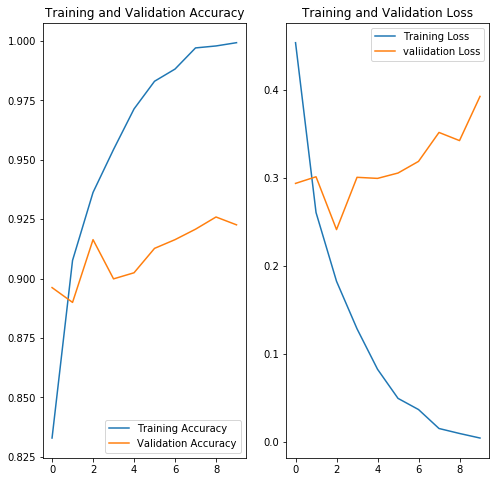

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='valiidation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
model_transfer.save('saved_model/transfer_lrn_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/transfer_lrn_model/assets


In [17]:
model_transfer.save('saved_model/transfer_lrn_model.h5')